# Agentic AI Research Gap Finder

An **Agentic AI** system built with **LangChain + LangGraph** that autonomously:
1. Generates a research plan from a topic
2. Searches arXiv for relevant papers
3. Extracts limitations from each paper
4. Clusters similar limitations using ChromaDB embeddings
5. Identifies common research gaps
6. Generates novel research ideas
7. Self-reflects and scores novelty (regenerates if < 7)
8. Saves results to a file

> **Agentic Flow**: The agent makes decisions at each step, loops back when quality is low, and operates end-to-end without human intervention.

In [34]:
# Install dependencies (run once)
# !pip install langchain-groq langgraph langchain-core langchain-community arxiv scikit-learn python-dotenv chromadb sentence-transformers

In [ ]:
import os
import json
import uuid
import arxiv
import numpy as np
from datetime import datetime
from typing import Annotated, Literal
from typing_extensions import TypedDict
from dotenv import load_dotenv

import chromadb
from chromadb.utils import embedding_functions
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity

from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END

load_dotenv()
print("All imports loaded.")

In [36]:
# Initialize the LLM
llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0.7,
)
print("LLM ready.")

LLM ready.


In [ ]:
# ---------- ChromaDB Setup + Session Manager ----------
CHROMA_DB_PATH = "./chroma_db"
SESSIONS_DIR = "./sessions"
os.makedirs(SESSIONS_DIR, exist_ok=True)

chroma_client = chromadb.PersistentClient(path=CHROMA_DB_PATH)

# Embedding function: runs locally, no API key needed
embedding_fn = embedding_functions.SentenceTransformerEmbeddingFunction(
    model_name="all-MiniLM-L6-v2"
)


def create_new_session():
    """Create a brand new session with a unique ID."""
    session_id = str(uuid.uuid4())[:8]
    print(f"  New session created: {session_id}")
    return session_id, None  # no previous state


def resume_session(json_path: str):
    """Resume a previous session from its output JSON file."""
    with open(json_path, "r") as f:
        data = json.load(f)

    session_id = data.get("session_id")
    if not session_id:
        raise ValueError("No session_id found in the provided JSON file. Cannot resume.")

    print(f"  Resuming session: {session_id}")
    print(f"  Previous topic: {data.get('topic')}")
    print(f"  Previous papers: {data.get('papers_found', 0)}")
    return session_id, data


def get_session_collections(session_id: str):
    """Get or create ChromaDB collections namespaced by session_id."""
    papers_col = chroma_client.get_or_create_collection(
        name=f"papers_{session_id}",
        embedding_function=embedding_fn,
    )
    limitations_col = chroma_client.get_or_create_collection(
        name=f"limitations_{session_id}",
        embedding_function=embedding_fn,
    )
    return papers_col, limitations_col


# These will be set after the user chooses new/resume
SESSION_ID = None
papers_collection = None
limitations_collection = None

print(f"ChromaDB ready at: {CHROMA_DB_PATH}")
print(f"Sessions directory: {SESSIONS_DIR}")

In [ ]:
# ---------- Agent State ----------
class AgentState(TypedDict):
    session_id: str                # Unique session identifier
    topic: str                     # User's research topic
    subtopics: list[str]           # Generated subtopics
    keywords: list[str]            # Search keywords
    papers: list[dict]             # Papers from arXiv
    limitations: list[str]         # Extracted limitation sentences
    clusters: list[dict]           # Clustered limitations
    gaps: list[str]                # Ranked common gaps
    ideas: list[str]               # Generated research ideas
    novelty_scores: list[int]      # Novelty ratings
    reflection_attempts: int       # How many times we've reflected
    output_file: str               # Path to saved results

In [39]:
# ---------- Step 1: Generate Research Plan ----------
def generate_plan(state: AgentState) -> dict:
    topic = state["topic"]
    print(f"\n[Step 1] Generating research plan for: {topic}")

    prompt = f"""You are a research assistant. Given the topic \"{topic}\", generate:
1. A list of 3-5 specific subtopics to investigate
2. A list of 5-8 search keywords/phrases for finding papers on arXiv

Return ONLY valid JSON in this format:
{{
  "subtopics": ["subtopic1", "subtopic2", ...],
  "keywords": ["keyword1", "keyword2", ...]
}}"""

    response = llm.invoke([HumanMessage(content=prompt)])
    
    # Parse the JSON from response
    text = response.content.strip()
    # Extract JSON if wrapped in markdown code block
    if "```" in text:
        text = text.split("```")[1]
        if text.startswith("json"):
            text = text[4:]
        text = text.strip()
    
    data = json.loads(text)
    print(f"  Subtopics: {data['subtopics']}")
    print(f"  Keywords: {data['keywords']}")
    
    return {"subtopics": data["subtopics"], "keywords": data["keywords"]}

In [ ]:
# ---------- Step 2: Search arXiv for Papers + Store in ChromaDB ----------
def search_papers(state: AgentState) -> dict:
    keywords = state["keywords"]
    print(f"\n[Step 2] Searching arXiv with {len(keywords)} keywords...")

    all_papers = []
    seen_ids = set()
    paper_id_counter = 1

    client = arxiv.Client()

    for kw in keywords:
        search = arxiv.Search(
            query=kw,
            max_results=3,
            sort_by=arxiv.SortCriterion.Relevance,
        )
        for result in client.results(search):
            if result.entry_id not in seen_ids:
                seen_ids.add(result.entry_id)
                authors_list = [a.name for a in result.authors[:3]]
                paper = {
                    "paper_id": paper_id_counter,
                    "title": result.title,
                    "summary": result.summary,
                    "url": result.entry_id,
                    "published": str(result.published.date()),
                    "authors": authors_list,
                    "citation_label": f"[Paper {paper_id_counter} - {authors_list[0].split()[-1]} {result.published.year}]",
                }
                all_papers.append(paper)
                paper_id_counter += 1

                # Store in ChromaDB for this session
                safe_id = result.entry_id.replace("/", "_").replace(":", "_")
                papers_collection.add(
                    documents=[result.summary],
                    metadatas=[{
                        "paper_id": paper["paper_id"],
                        "title": result.title,
                        "url": result.entry_id,
                        "published": str(result.published.date()),
                        "authors": ", ".join(authors_list),
                        "citation_label": paper["citation_label"],
                    }],
                    ids=[safe_id],
                )

    print(f"  Found {len(all_papers)} unique papers.")
    for i, p in enumerate(all_papers[:5]):
        print(f"    {i+1}. {p['citation_label']} {p['title'][:70]}...")
    if len(all_papers) > 5:
        print(f"    ... and {len(all_papers)-5} more")

    return {"papers": all_papers}

In [ ]:
# ---------- Step 3: Extract Limitations (with paper citations) ----------
def extract_limitations(state: AgentState) -> dict:
    papers = state["papers"]
    print(f"\n[Step 3] Extracting limitations from {len(papers)} papers...")

    all_limitations = []

    # Process papers in batches to avoid token limits
    batch_size = 5
    for i in range(0, len(papers), batch_size):
        batch = papers[i:i+batch_size]
        papers_text = ""
        for j, p in enumerate(batch):
            papers_text += f"\n--- {p['citation_label']}: {p['title']} ---\n{p['summary']}\n"

        prompt = f"""Analyze these paper abstracts and extract specific limitations, 
weaknesses, and future work suggestions mentioned or implied.

{papers_text}

Return ONLY valid JSON — an array of objects. For each limitation, include the paper_id it came from.
Example:
[
  {{"limitation": "The method fails on small datasets.", "paper_id": 1}},
  {{"limitation": "No evaluation on real-world data.", "paper_id": 2}}
]"""

        response = llm.invoke([HumanMessage(content=prompt)])
        text = response.content.strip()
        if "```" in text:
            text = text.split("```")[1]
            if text.startswith("json"):
                text = text[4:]
            text = text.strip()

        try:
            limitations_data = json.loads(text)
            for item in limitations_data:
                if isinstance(item, dict) and "limitation" in item:
                    all_limitations.append({
                        "text": item["limitation"],
                        "paper_id": item.get("paper_id"),
                    })
                elif isinstance(item, str):
                    all_limitations.append({"text": item, "paper_id": None})
        except json.JSONDecodeError:
            for line in text.split("\n"):
                line = line.strip().strip('",-[]')
                if len(line) > 20:
                    all_limitations.append({"text": line, "paper_id": None})

    # Build a lookup for citation labels
    paper_lookup = {p["paper_id"]: p["citation_label"] for p in papers}
    for lim in all_limitations:
        pid = lim.get("paper_id")
        lim["citation_label"] = paper_lookup.get(pid, "[Unknown]") if pid else "[Unknown]"

    print(f"  Extracted {len(all_limitations)} limitations.")
    for lim in all_limitations[:5]:
        print(f"    - {lim['citation_label']} {lim['text'][:80]}")

    return {"limitations": all_limitations}

In [ ]:
# ---------- Step 4: Cluster Limitations using ChromaDB Embeddings ----------
def cluster_limitations(state: AgentState) -> dict:
    limitations = state["limitations"]
    topic = state.get("topic", "research")
    print(f"\n[Step 4] Clustering {len(limitations)} limitations using ChromaDB embeddings...")

    # Extract text for embedding; keep full objects for citation tracking
    lim_texts = [l["text"] if isinstance(l, dict) else l for l in limitations]

    if len(lim_texts) < 3:
        clusters = [{"theme": "General", "limitations": limitations}]
        return {"clusters": clusters}

    # Store limitations in ChromaDB and get embeddings
    run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
    ids = [f"lim_{run_id}_{i}" for i in range(len(lim_texts))]

    limitations_collection.add(
        documents=lim_texts,
        metadatas=[{
            "topic": topic,
            "paper_id": str(l.get("paper_id", "")) if isinstance(l, dict) else "",
            "citation_label": l.get("citation_label", "") if isinstance(l, dict) else "",
        } for l in limitations],
        ids=ids,
    )
    print(f"  Stored {len(lim_texts)} limitations in ChromaDB.")

    # Retrieve embeddings from ChromaDB
    result = limitations_collection.get(ids=ids, include=["embeddings"])
    embeddings = np.array(result["embeddings"])

    # Cosine similarity on ChromaDB embeddings
    sim_matrix = cosine_similarity(embeddings)
    distance_matrix = 1 - sim_matrix
    np.fill_diagonal(distance_matrix, 0)
    distance_matrix = np.clip(distance_matrix, 0, None)

    # Agglomerative clustering
    n_clusters = min(max(2, len(lim_texts) // 3), 8)
    clustering = AgglomerativeClustering(
        n_clusters=n_clusters,
        metric="precomputed",
        linkage="average",
    )
    labels = clustering.fit_predict(distance_matrix)

    # Group by cluster — keep full limitation objects (with citations)
    clusters_dict = {}
    for idx, label in enumerate(labels):
        clusters_dict.setdefault(int(label), []).append(limitations[idx])

    # Ask LLM to name each cluster
    clusters = []
    for label, lims in clusters_dict.items():
        sample = "; ".join(l["text"] if isinstance(l, dict) else l for l in lims[:3])
        resp = llm.invoke([HumanMessage(
            content=f"Give a short 3-5 word theme name for these limitations: {sample}. Reply with ONLY the theme name."
        )])
        theme = resp.content.strip().strip('"')

        # Collect unique cited paper_ids for this cluster
        cited_papers = list(set(
            l.get("paper_id") for l in lims
            if isinstance(l, dict) and l.get("paper_id")
        ))

        clusters.append({
            "theme": theme,
            "limitations": lims,
            "count": len(lims),
            "cited_paper_ids": cited_papers,
        })

    clusters.sort(key=lambda c: c["count"], reverse=True)
    print(f"  Formed {len(clusters)} clusters:")
    for c in clusters:
        print(f"    [{c['count']} items] {c['theme']}  (cites papers: {c['cited_paper_ids']})")

    return {"clusters": clusters}

In [ ]:
# ---------- Step 5: Identify Common Gaps (with citations) ----------
def identify_gaps(state: AgentState) -> dict:
    clusters = state["clusters"]
    papers = state["papers"]
    print(f"\n[Step 5] Identifying top research gaps...")

    # Build paper lookup for citation labels
    paper_lookup = {p["paper_id"]: p["citation_label"] for p in papers}

    cluster_summary = ""
    for c in clusters:
        cited = ", ".join(paper_lookup.get(pid, f"[Paper {pid}]") for pid in c.get("cited_paper_ids", []))
        cluster_summary += f"\nCluster '{c['theme']}' ({c.get('count', len(c['limitations']))} papers, cited by: {cited}):\n"
        for lim in c["limitations"][:3]:
            lim_text = lim["text"] if isinstance(lim, dict) else lim
            lim_cite = lim.get("citation_label", "") if isinstance(lim, dict) else ""
            cluster_summary += f"  - {lim_cite} {lim_text}\n"

    prompt = f"""Based on these clustered research limitations (with paper citations), identify the top 3-5 most 
significant and recurring research gaps. For each gap, list which paper numbers support it.

{cluster_summary}

Return ONLY a JSON array:
[
  {{"gap": "description of the gap", "supporting_papers": [1, 3, 5]}}
]"""

    response = llm.invoke([HumanMessage(content=prompt)])
    text = response.content.strip()
    if "```" in text:
        text = text.split("```")[1]
        if text.startswith("json"):
            text = text[4:]
        text = text.strip()

    gaps_data = json.loads(text)

    # Normalize: ensure each gap has supporting_papers
    gaps = []
    for g in gaps_data:
        if isinstance(g, str):
            gaps.append({"gap": g, "supporting_papers": []})
        else:
            gaps.append({
                "gap": g.get("gap", str(g)),
                "supporting_papers": g.get("supporting_papers", []),
            })

    print(f"  Found {len(gaps)} key gaps:")
    for i, g in enumerate(gaps):
        cited = ", ".join(paper_lookup.get(pid, f"[Paper {pid}]") for pid in g["supporting_papers"])
        print(f"    {i+1}. {g['gap']}")
        print(f"       Cited by: {cited}")

    return {"gaps": gaps}

In [ ]:
# ---------- Step 6: Generate Research Ideas (with citations) ----------
def generate_ideas(state: AgentState) -> dict:
    gaps = state["gaps"]
    topic = state["topic"]
    papers = state["papers"]
    print(f"\n[Step 6] Generating research ideas...")

    # Build paper lookup and reference context
    paper_lookup = {p["paper_id"]: p for p in papers}

    gaps_text = ""
    all_cited_ids = set()
    for g in gaps:
        gap_str = g["gap"] if isinstance(g, dict) else g
        supporting = g.get("supporting_papers", []) if isinstance(g, dict) else []
        cited = ", ".join(f"[Paper {pid}]" for pid in supporting)
        gaps_text += f"- {gap_str} (supported by: {cited})\n"
        all_cited_ids.update(supporting)

    # Build a reference context block for the LLM
    ref_context = "\n--- Reference Papers ---\n"
    for pid in sorted(all_cited_ids):
        p = paper_lookup.get(pid)
        if p:
            ref_context += f"{p['citation_label']}: \"{p['title']}\" by {', '.join(p['authors'])}\n"

    prompt = f"""You are a creative research scientist. Based on these recurring research 
gaps in the field of \"{topic}\":

{gaps_text}

{ref_context}

Propose 3 novel research ideas. For each idea:
- Provide a clear title
- A 2-3 sentence description of the approach
- Which gap(s) it addresses
- Cite the relevant paper numbers that inform this idea

Return ONLY a JSON array:
[
  {{
    "title": "...",
    "description": "...",
    "addresses_gaps": ["gap1", ...],
    "cited_papers": [1, 3]
  }}
]"""

    response = llm.invoke([HumanMessage(content=prompt)])
    text = response.content.strip()
    if "```" in text:
        text = text.split("```")[1]
        if text.startswith("json"):
            text = text[4:]
        text = text.strip()

    ideas = json.loads(text)
    print(f"  Generated {len(ideas)} ideas:")
    for idea in ideas:
        cited = ", ".join(
            paper_lookup[pid]["citation_label"]
            for pid in idea.get("cited_papers", [])
            if pid in paper_lookup
        )
        print(f"    -> {idea['title']}  (cites: {cited})")

    return {"ideas": ideas, "reflection_attempts": 0}

In [45]:
# ---------- Step 7: Reflection (Novelty Scoring) ----------
def reflect_on_ideas(state: AgentState) -> dict:
    ideas = state["ideas"]
    attempts = state.get("reflection_attempts", 0)
    print(f"\n[Step 7] Reflecting on ideas (attempt {attempts + 1})...")

    ideas_text = json.dumps(ideas, indent=2)

    prompt = f"""Rate each of these research ideas for novelty on a scale of 1-10.
Consider: Is the idea truly new? Does it go beyond incremental improvement?

{ideas_text}

Return ONLY a JSON array of objects:
[
  {{"title": "...", "novelty_score": 8, "feedback": "why this score"}}
]"""

    response = llm.invoke([HumanMessage(content=prompt)])
    text = response.content.strip()
    if "```" in text:
        text = text.split("```")[1]
        if text.startswith("json"):
            text = text[4:]
        text = text.strip()

    scores_data = json.loads(text)
    scores = [s["novelty_score"] for s in scores_data]

    print(f"  Scores: {scores}")
    for s in scores_data:
        print(f"    {s['title']}: {s['novelty_score']}/10 - {s['feedback'][:60]}")

    return {
        "novelty_scores": scores,
        "reflection_attempts": attempts + 1,
    }


# Conditional edge: should we regenerate ideas?
def should_regenerate(state: AgentState) -> Literal["regenerate", "save"]:
    scores = state.get("novelty_scores", [])
    attempts = state.get("reflection_attempts", 0)
    avg_score = sum(scores) / len(scores) if scores else 0

    if avg_score < 7 and attempts < 3:
        print(f"  Average novelty {avg_score:.1f} < 7 -> regenerating (attempt {attempts})")
        return "regenerate"
    else:
        if avg_score >= 7:
            print(f"  Average novelty {avg_score:.1f} >= 7 -> proceeding to save!")
        else:
            print(f"  Max reflection attempts reached -> proceeding to save.")
        return "save"

In [ ]:
# ---------- Step 8: Save Results (with session_id & references) ----------
def save_results(state: AgentState) -> dict:
    print(f"\n[Step 8] Saving results...")

    session_id = state.get("session_id", "unknown")
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = os.path.join(SESSIONS_DIR, f"session_{session_id}_{timestamp}.json")

    # Build the reference list from papers
    papers = state.get("papers", [])
    references = []
    for p in papers:
        references.append({
            "paper_id": p["paper_id"],
            "citation_label": p["citation_label"],
            "title": p["title"],
            "authors": p["authors"],
            "published": p["published"],
            "url": p["url"],
        })

    output = {
        "session_id": session_id,
        "topic": state["topic"],
        "subtopics": state.get("subtopics", []),
        "keywords": state.get("keywords", []),
        "papers_found": len(papers),
        "papers": state.get("papers", []),
        "limitations_extracted": len(state.get("limitations", [])),
        "limitations": state.get("limitations", []),
        "clusters": [
            {
                "theme": c["theme"],
                "count": c["count"],
                "cited_paper_ids": c.get("cited_paper_ids", []),
                "limitations": [
                    {"text": l["text"] if isinstance(l, dict) else l,
                     "citation_label": l.get("citation_label", "") if isinstance(l, dict) else ""}
                    for l in c["limitations"]
                ],
            }
            for c in state.get("clusters", [])
        ],
        "research_gaps": state.get("gaps", []),
        "research_ideas": state.get("ideas", []),
        "novelty_scores": state.get("novelty_scores", []),
        "references": references,
        "generated_at": datetime.now().isoformat(),
        "chroma_db": {
            "session_id": session_id,
            "path": CHROMA_DB_PATH,
            "papers_collection": f"papers_{session_id}",
            "limitations_collection": f"limitations_{session_id}",
            "total_papers_stored": papers_collection.count(),
            "total_limitations_stored": limitations_collection.count(),
        },
    }

    with open(filename, "w") as f:
        json.dump(output, f, indent=2)

    print(f"  Session ID: {session_id}")
    print(f"  Results saved to: {filename}")
    print(f"  ChromaDB collections: papers_{session_id}, limitations_{session_id}")
    print(f"    Papers in vector DB: {papers_collection.count()}")
    print(f"    Limitations in vector DB: {limitations_collection.count()}")
    print(f"\n  To resume this session later, provide this JSON file.")
    return {"output_file": filename}

In [47]:
# ---------- Build the LangGraph ----------
workflow = StateGraph(AgentState)

# Add all nodes
workflow.add_node("generate_plan", generate_plan)
workflow.add_node("search_papers", search_papers)
workflow.add_node("extract_limitations", extract_limitations)
workflow.add_node("cluster_limitations", cluster_limitations)
workflow.add_node("identify_gaps", identify_gaps)
workflow.add_node("generate_ideas", generate_ideas)
workflow.add_node("reflect", reflect_on_ideas)
workflow.add_node("save_results", save_results)

# Define edges (the flow)
workflow.add_edge(START, "generate_plan")
workflow.add_edge("generate_plan", "search_papers")
workflow.add_edge("search_papers", "extract_limitations")
workflow.add_edge("extract_limitations", "cluster_limitations")
workflow.add_edge("cluster_limitations", "identify_gaps")
workflow.add_edge("identify_gaps", "generate_ideas")
workflow.add_edge("generate_ideas", "reflect")

# Conditional: reflect -> regenerate ideas OR save
workflow.add_conditional_edges(
    "reflect",
    should_regenerate,
    {"regenerate": "generate_ideas", "save": "save_results"},
)
workflow.add_edge("save_results", END)

# Compile the graph
agent = workflow.compile()
print("Research agent compiled!")

Research agent compiled!


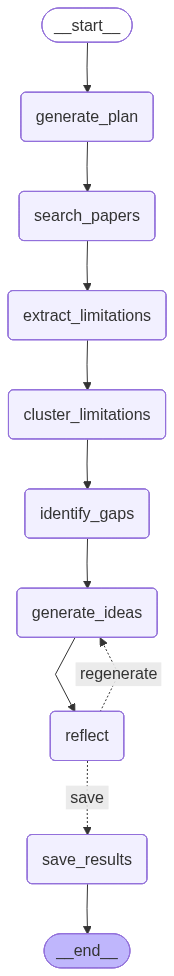

In [48]:
# Visualize the agent graph
from IPython.display import Image, display

try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception:
    print(agent.get_graph().print_ascii())

In [ ]:
# ---------- Run the Agent (New Session or Resume) ----------

print("="*60)
print("  Research Gap Finder Agent — Session Manager")
print("="*60)
print("\nOptions:")
print("  1. Start a NEW session")
print("  2. RESUME a previous session (provide JSON file path)")

choice = input("\nEnter choice (1 or 2): ").strip()

if choice == "2":
    # ---------- RESUME existing session ----------
    json_path = input("Enter path to previous session JSON file: ").strip()
    SESSION_ID, prev_data = resume_session(json_path)
    papers_collection, limitations_collection = get_session_collections(SESSION_ID)

    # Rebuild state from previous JSON — the agent continues from where it left off
    # The user's old ChromaDB vectors are still in their session-scoped collections
    topic = prev_data["topic"]

    print(f"\n  Session {SESSION_ID} restored!")
    print(f"  ChromaDB collections: papers_{SESSION_ID} ({papers_collection.count()} papers), "
          f"limitations_{SESSION_ID} ({limitations_collection.count()} limitations)")
    print(f"  Previous topic: {topic}")
    print(f"  Previous papers: {prev_data.get('papers_found', 0)}")

    # Ask what the user wants to do with the resumed session
    print("\nResume options:")
    print("  a. Re-run with the SAME topic (fetch new papers, keep old ones too)")
    print("  b. Run with a NEW topic (adds to this session's data)")
    resume_choice = input("Enter choice (a or b): ").strip().lower()

    if resume_choice == "b":
        topic = input("Enter new research topic: ").strip()

    initial_state = {
        "session_id": SESSION_ID,
        "topic": topic,
    }

else:
    # ---------- NEW session ----------
    SESSION_ID, _ = create_new_session()
    papers_collection, limitations_collection = get_session_collections(SESSION_ID)

    topic = input("Enter your research topic: ").strip()
    initial_state = {
        "session_id": SESSION_ID,
        "topic": topic,
    }

print(f"\n{'='*60}")
print(f"  Session ID : {SESSION_ID}")
print(f"  Topic      : {topic}")
print(f"  Collections: papers_{SESSION_ID}, limitations_{SESSION_ID}")
print(f"{'='*60}")

result = agent.invoke(initial_state)

print(f"\n{'='*60}")
print(f"  DONE! Session: {SESSION_ID}")
print(f"  Results saved to: {result['output_file']}")
print(f"  Provide this JSON file to resume later.")
print(f"{'='*60}")

In [ ]:
# ---------- Display Final Summary (with session, citations & references) ----------
papers = result.get("papers", [])
paper_lookup = {p["paper_id"]: p for p in papers}

print("\n" + "="*60)
print(f"  SESSION: {result.get('session_id', SESSION_ID)}")
print("="*60)

print("\n" + "="*60)
print("  RESEARCH GAPS FOUND")
print("="*60)
for i, gap in enumerate(result.get("gaps", [])):
    if isinstance(gap, dict):
        gap_text = gap["gap"]
        cited = ", ".join(
            paper_lookup[pid]["citation_label"]
            for pid in gap.get("supporting_papers", [])
            if pid in paper_lookup
        )
        print(f"  {i+1}. {gap_text}")
        if cited:
            print(f"     Sources: {cited}")
    else:
        print(f"  {i+1}. {gap}")

print("\n" + "="*60)
print("  RESEARCH IDEAS")
print("="*60)
for i, idea in enumerate(result.get("ideas", [])):
    score = result["novelty_scores"][i] if i < len(result.get("novelty_scores", [])) else "?"
    print(f"\n  Idea {i+1} (Novelty: {score}/10): {idea['title']}")
    print(f"    {idea['description']}")
    print(f"    Addresses: {', '.join(idea.get('addresses_gaps', []))}")
    cited = ", ".join(
        paper_lookup[pid]["citation_label"]
        for pid in idea.get("cited_papers", [])
        if pid in paper_lookup
    )
    if cited:
        print(f"    Cited papers: {cited}")

print(f"\n  Papers analyzed: {len(papers)}")
print(f"  Limitations found: {len(result.get('limitations', []))}")
print(f"  Clusters formed: {len(result.get('clusters', []))}")

# ---------- Full Reference List ----------
print("\n" + "="*60)
print("  REFERENCES")
print("="*60)
for p in papers:
    authors_str = ", ".join(p["authors"])
    print(f"  {p['citation_label']}")
    print(f"    {authors_str}. \"{p['title']}.\" ({p['published']})")
    print(f"    {p['url']}")
    print()

print("="*60)
print(f"  Session ID: {result.get('session_id', SESSION_ID)}")
print(f"  Output file: {result.get('output_file', 'N/A')}")
print(f"  To resume: provide the output JSON file when starting a new run.")
print("="*60)